# Deepfake Detection with InceptionV3

by

Name: *Ventsislav V. Dimitrov*  
SoftUni username: *nechoventsi*

Deep learining models are getting really good at generating fake human faces. This constitutes a real problem for various services, like automatic ID verification (i.e. for banking apps), fake persona representation on social media, deepfake videos, catfishing, etc.

With this model, we're aiming to test a Transfer Learning strategy for the detection and classification of real and fake human faces.

The dataset used is a collection of human faces, 70 000 of which are real photographs of people (the [Flickr- Faces-HQ](https://github.com/NVlabs/ffhq-dataset) (FFHQ) dataset collected by Nvidia [1]), while the other 70 000 are GAN-generated fake human faces. The dataset used in the current work is [available on Kaggle](https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces) [2] and is pre-split into train, validation and test sets.

## Download dataset from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset                Hotel Reservations Dataset                          480KB  2023-01-04 12:50:31           7358        261  1.0              
themrityunjaypathak/most-subscribed-1000-youtube-channels        Most Subscribed 1000 Youtube Channels                28KB  2023-01-21 14:42:05           1386         51  1.0              
senapatirajesh/netflix-tv-shows-and-movies                       Latest Netflix TV shows and movies                    1MB  2023-01-14 17:03:12           2756         73  0.9411765        
ulrikthygepedersen/on

In [ ]:
! kaggle datasets download "xhlulu/140k-real-and-fake-faces"

100% 3.75G/3.75G [01:44<00:00, 39.3MB/s]
100% 3.75G/3.75G [01:44<00:00, 38.4MB/s]


In [ ]:
! unzip -qq /content/140k-real-and-fake-faces.zip

## 1. Imports

In [ ]:
import os
import glob
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn import metrics

## 2. Constants

In [3]:
# Directory containing the data:
data_path = "/content/real_vs_fake/real-vs-fake/"

# Define the classes as variables:
data_classes = os.listdir(os.path.join(data_path, "train"))
data_classes

## 3. Check data

Create a dataframe to check the length of the dataset, and the value counts for the train, validation and test sets.  
Plot sample images to check the resolution and number of channels (should be RGB).

In [ ]:
data_dict = {"img_path":[],"label":[],"part":[]}

for part in os.listdir(data_path):
    for label in os.listdir(data_path + "/" + part):
        for img in glob.glob(data_path + part + "/" + label + "/" + "*.jpg"):
            data_dict["img_path"].append(img)
            data_dict["label"].append(label)
            data_dict["part"].append(part)
df = pd.DataFrame(data_dict)

In [ ]:
df.head()

,img_path,label,part
0,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
1,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
2,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
3,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
4,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid


In [ ]:
# Classes counts:
df["label"].value_counts()

real    70000
fake    70000
Name: label, dtype: int64

In [ ]:
# Train, validation, test counts:
df["part"].value_counts()

train    100000
valid     20000
test      20000
Name: part, dtype: int64

Sample `real` image:


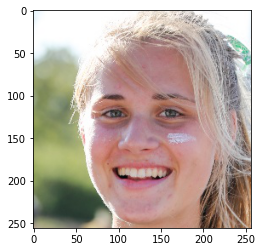


Sample `fake` image:


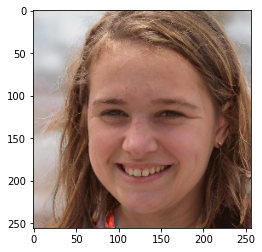

In [ ]:
# Plot a fake face:
print(f"Sample `{data_classes[0]}` image:")
plt.imshow(load_img(os.path.join(data_path + "train", data_classes[0], os.listdir(data_path + "train/" + data_classes[0])[0])))
plt.show()

# Plot a real face:
print(f"\nSample `{data_classes[1]}` image:")
plt.imshow(load_img(os.path.join(data_path + "train", data_classes[1], os.listdir(data_path + "train/" + data_classes[1])[0])))
plt.show()

In [ ]:
# Load a sample fake face image:
sample_fake_img  = load_img(os.path.join(data_path + "train", data_classes[0], os.listdir(data_path + "train/" + data_classes[0])[0]))
# Convert the image into array representation to check dimensions:
sample_fake_array = img_to_array(sample_fake_img)
# Show the shape:
print(f"Shape of `{data_classes[0]}` images: {sample_fake_array.shape}")

# Load a sample real face image:
sample_real_img  = load_img(os.path.join(data_path + "train", data_classes[1], os.listdir(data_path + "train/" + data_classes[1])[0]))
# Convert the image into array representation to check dimensions:
sample_real_array = img_to_array(sample_real_img)
# Show the shape:
print(f"Shape of `{data_classes[1]}` images: {sample_real_array.shape}")

Shape of `real` images: (256, 256, 3)
Shape of `fake` images: (256, 256, 3)


## 4. Construct dataset

In [ ]:
# Define a data generator function that will limit repetitive code, 
# as we have data pre-split into train, validation and test sets.
def get_data_generator(data_directory, class_mode, batch_size=32, resize_to=(256, 256), preprocessing_function=None):
    """Create a data generator from a directory containing images.

    Params:
    -------
    data_directory :: string  
        The path containing the image data  
    class_mode :: str  
        One of 'categorical', 'binary', 'sparse', 'input', or `None`.  
        Determines the type of label arrays that are returned:  
            - 'categorical' will be 2D one-hot encoded labels;  
            - 'binary' will be 1D binary labels;  
            - 'sparse' will be 1D integer labels;  
            - 'input' will be images identical to input images (mainly used to work with autoencoders).  
    batch_size :: int  
        Custom batch size. Default: 32  
    resize_to :: tuple  
        New image size. Default: (256, 256)  
    preprocessing_function :: function  
        The images pre-processing function to use for the data generator. Default: `None`

    Returns:
    --------
    data_generator :: keras DirectoryIterator  
        The iterator object to load the data from directory"""

    # Instantiate the generator, normalise pixel values:
    img_generator = ImageDataGenerator(rescale=1./255,
                                       preprocessing_function=preprocessing_function)

    # Generate data. Set batch size, class mode and image size.
    # Don't forget seed for reproducibility:
    data_generator = img_generator.flow_from_directory(directory=data_directory,
                                                       batch_size=batch_size,
                                                       class_mode=class_mode,
                                                       target_size=resize_to,
                                                       seed=666)

    # Return the generated data:
    return data_generator

In [ ]:
# Initial batch size:
BATCH_SIZE = 128

In [ ]:
# Create the training set generator:
train_generator = get_data_generator(data_directory=data_path+"train/",
                                     class_mode="binary",
                                     batch_size=BATCH_SIZE,
                                     resize_to=(224, 224),
                                     preprocessing_function=preprocess_input)
# Create the validation set generator:
val_generator = get_data_generator(data_directory=data_path+"valid/",
                                   class_mode="binary",
                                   batch_size=BATCH_SIZE,
                                   resize_to=(224, 224),
                                   preprocessing_function=preprocess_input)
# Create the test set generator:
test_generator = get_data_generator(data_directory=data_path+"test/",
                                    class_mode="binary",
                                    batch_size=1,
                                    resize_to=(224, 224),
                                    preprocessing_function=preprocess_input)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## 5. Transfer learning with InceptionV3

Here we will test the [InceptionV3](https://keras.io/api/applications/inceptionv3/) pre-trained model [3], but we will keep all the layers unfrozen so we can train the whole network. We will use, as with the other experiments, Adam as an optimiser [4].

In [ ]:
# Instantiate the VGG19 model:
base_InceptionV3 = InceptionV3(include_top=False,
                   weights="imagenet")

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
x = base_InceptionV3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation = "sigmoid")(x) 

model = Model(inputs=base_InceptionV3.input, outputs=predictions)

model.compile(optimizer = Adam(), 
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [ ]:
# Model summary:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
# Calculate the number of steps per epoch:
train_steps = 100000 // BATCH_SIZE
val_steps = 20000 // BATCH_SIZE

# Instantiate callbacks:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=3, min_lr=0.00001)

checkpoint_path = "weights.h5"

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor="val_accuracy",
                             mode="min",
                             save_freq="epoch")

# Time the training:
start_time = time.time()

# Fit model with generator:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    epochs=10,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

# Time the training:
end_time = time.time()
print(f"Training time: {round((end_time - start_time) / 60)} minutes.")

Epoch 1/10
781/781 [==============================] - 796s 989ms/step - loss: 0.1203 - accuracy: 0.9508 - val_loss: 1.6236 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 2/10
781/781 [==============================] - 765s 980ms/step - loss: 0.0285 - accuracy: 0.9896 - val_loss: 1.1243 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 3/10
781/781 [==============================] - 763s 976ms/step - loss: 0.0193 - accuracy: 0.9930 - val_loss: 2.8675 - val_accuracy: 0.5005 - lr: 0.0010
Epoch 4/10
781/781 [==============================] - 762s 976ms/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.7073 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 5/10
781/781 [==============================] - 762s 975ms/step - loss: 0.0120 - accuracy: 0.9959 - val_loss: 0.7168 - val_accuracy: 0.5115 - lr: 0.0010
Epoch 6/10
781/781 [==============================] - 762s 975ms/step - loss: 0.0105 - accuracy: 0.9964 - val_loss: 1.0265 - val_accuracy: 0.5005 - lr: 0.0010
Epoch 7/10
781/781 [==========================

#### 5.1.1. Save the model for future reference and/or use

In [ ]:
# Save the model object:
model.save("InceptionV3_model.h5", save_format="h5")
# # Save the history to a DataFrame:
history_df = pd.DataFrame(history.history)
# # Save the history DataFrame to a file:
history_df.to_csv("InceptionV3_history.csv", index=False)

#### 5.1.2. Model performance exploration

Following is a simple exploration of the model performance, along with an evaluation on the testing part of the dataset.

In [ ]:
def plot_metric(history, metric):
    """Plot the chosen metric curves for eaasy visualisation.

    Params:
    -------
    history :: keras History object  
        The information for events during training  
    metric :: str  
        The metric of choice to plot"""

    # Train metric:
    train_metric = history.history[metric]
    # Validation metric:
    val_metric = history.history["val_" + metric]
    # The range of epochs for the X axis:
    epochs = range(len(train_metric))
    # Plot the epochs on the X axis vs. the metric on the Y axis:
    plt.plot(epochs, train_metric)
    plt.plot(epochs, val_metric)
    # Title, labels, legend:
    plt.title("Training and validation " + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, "val_" + metric])
    # Show plot:
    plt.show()

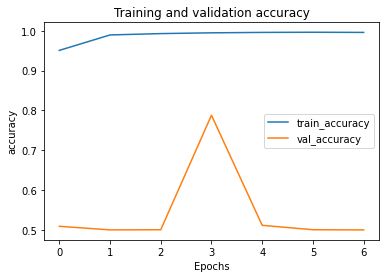

In [ ]:
# Plot training and validation accuracy curves:
plot_metric(history=history, metric="accuracy")

In [ ]:
# Run model.predict on the unseen test data:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

20000/20000 [==============================] - 250s 12ms/step


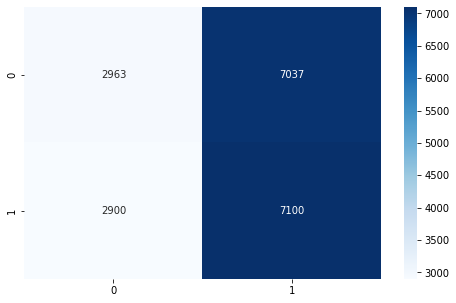

In [ ]:
# Show a confusion matrix for the test predictions:
plt.figure(figsize = (8, 5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot=True, fmt="d", cmap = "Blues")
plt.show()

In [ ]:
# Check Area Under the Curve score:
print("ROC-AUC Score:", round(metrics.roc_auc_score(y_test, y_pred), 2))
# Check average precision score:
print("AP Score:", round(metrics.average_precision_score(y_test, y_pred), 2))

# Show classification report:
print("\n", metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.5
AP Score: 0.5

               precision    recall  f1-score   support

           0       0.51      0.30      0.37     10000
           1       0.50      0.71      0.59     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.50      0.50      0.48     20000



## Conclusion

The InceptionV3 model with unfrozen layers is also not performing well. More experiments are needed to check if other parameters would help raise the accuracy above 50%.

## References

- [1] T. Karras, S. Laine and T. Aila, "A Style-Based Generator Architecture for Generative Adversarial Networks," 2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), Long Beach, CA, USA, 2019, pp. 4396-4405, doi: 10.1109/CVPR.2019.00453.
- [2] https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
- [3] Szegedy, Christian et al. “Rethinking the Inception Architecture for Computer Vision.” 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR) (2015)
- [4] Kingma, Diederik P. and Jimmy Ba. “Adam: A Method for Stochastic Optimization.” CoRR abs/1412.6980 (2014)